# 🚀 BizInsight AI — Automated Competitive Analysis & Report Generator  
**Track:** Enterprise Agents

BizInsight AI is a **multi-agent competitive intelligence system** that automatically collects, analyzes, compares, and summarizes real-world competitor insights. It transforms messy product review text into **clear strategic reports**, helping product, marketing, and business teams make informed decisions.

---

## 🔍 Why Agents?
Competitive analysis is a multi-step, repetitive process:
- Collecting information on multiple companies  
- Reading hundreds of reviews  
- Extracting themes and customer pain points  
- Comparing features and pricing  
- Creating an insights report  

Agents solve this by:
- Splitting the work into **specialized sub-agents**  
- Running tasks **in parallel**  
- Producing **traceable outputs** (logs, session files)  
- Generating final reports automatically  

BizInsight AI acts like a **virtual competitive analyst**.

---

## 🧠 Architecture Overview
The system uses these agents:

- **Collector Agent** → Loads and normalizes reviews  
- **Sentiment Agent** → Computes per-review & average sentiment  
- **Theme Agent** → Finds recurring topics (battery, pricing, UI…)  
- **Comparison Agent** → Feature parity between companies  
- **Insights Agent** → High-level recommendations  
- **Report Generator** → Markdown reports + sentiment charts  
- **Orchestrator** → Manages workflow, parallelism, logs, memory  

Outputs include:
- `report_<company>.md`  
- Sentiment charts (`*.png`)  
- Session logs (`*_session.json`)  
- Metrics summary (`*_metrics.json`)  

---

## 🧪 Demo 1 — Mock Data (Reproducible)
The notebook first runs using two mock companies:



Install lightweight libs (if needed) and import Python modules.

In [1]:
# Install minimal deps (run once)
!pip install -q beautifulsoup4 pandas matplotlib

# Imports
import os, json, time, uuid, logging
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass, asdict
from typing import List, Dict, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
print("✔ Libraries installed and imported successfully.")

✔ Libraries installed and imported successfully.


Create working directories and constants used across the notebook.

In [2]:
WORKDIR = "/kaggle/working/bizinsight_ai"
os.makedirs(WORKDIR, exist_ok=True)
DATA_DIR = "/kaggle/input/sample-biz-data"  # if you upload a Kaggle dataset, else we'll create sample data
RUN_ID = lambda: f"run_{int(time.time())}"
SEO_THRESHOLD = 0.7
print(f"✔ WORKDIR set to: {WORKDIR}\n✔ DATA_DIR set to: {DATA_DIR}\n✔ Environment initialized successfully.")

✔ WORKDIR set to: /kaggle/working/bizinsight_ai
✔ DATA_DIR set to: /kaggle/input/sample-biz-data
✔ Environment initialized successfully.


Structured logger and helper functions for saving JSON.

In [3]:
# Simple structured logger
logger = logging.getLogger("bizinsight")
logger.setLevel(logging.INFO)
if not logger.handlers:
    h = logging.FileHandler(os.path.join(WORKDIR, "run.log"))
    fmt = logging.Formatter('{"time":"%(asctime)s","run_id":"%(name)s","level":"%(levelname)s","msg":"%(message)s"}')
    h.setFormatter(fmt)
    logger.addHandler(h)

def log_info(msg, **extra):
    logger.info(msg + " | " + json.dumps(extra))

def save_json(path, obj):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2, ensure_ascii=False)
print(f"✔ Logger initialized and writing to: {os.path.join(WORKDIR, 'run.log')}")

✔ Logger initialized and writing to: /kaggle/working/bizinsight_ai/run.log


Lightweight session tracker and memory bank helpers.

In [4]:
class InMemorySession:
    def __init__(self, workdir):
        self.workdir = workdir
        self.sessions = {}
    def start(self, run_id, companies):
        self.sessions[run_id] = {"companies": companies, "start": time.time(), "outputs": {}}
        return self.sessions[run_id]
    def save_output(self, run_id, key, obj):
        self.sessions[run_id]["outputs"][key] = obj
        save_json(os.path.join(self.workdir, f"{run_id}_{key}.json"), obj)
    def finish(self, run_id):
        self.sessions[run_id]["end"] = time.time()
        save_json(os.path.join(self.workdir, f"{run_id}_session.json"), self.sessions[run_id])

# simple long-term memory as JSON file
MEMORY_FILE = os.path.join(WORKDIR, "memory_bank.json")
if not os.path.exists(MEMORY_FILE):
    save_json(MEMORY_FILE, {})

def load_memory():
    with open(MEMORY_FILE, "r", encoding="utf-8") as f:
        return json.load(f)
def update_memory(product_key, snapshot):
    mem = load_memory()
    mem.setdefault(product_key, []).append(snapshot)
    save_json(MEMORY_FILE, mem)
print("✔ Session system initialized.\n✔ Memory bank loaded at:", MEMORY_FILE)

✔ Session system initialized.
✔ Memory bank loaded at: /kaggle/working/bizinsight_ai/memory_bank.json


Create a small synthetic dataset for demo runs. This avoids external APIs and ensures reproducibility.

In [5]:
# Create small sample dataset in-memory for demo
sample = {
    "AcmeCorp": [
        {"id":"a1","text":"Great battery life but shipping was slow. Price is high.","rating":4,"source":"shopA","date":"2025-10-01"},
        {"id":"a2","text":"Customer support was unhelpful. Love the UI.","rating":3,"source":"shopB","date":"2025-10-05"},
        {"id":"a3","text":"Price is confusing, discounts unclear.","rating":2,"source":"shopA","date":"2025-11-01"},
    ],
    "ExampleCo": [
        {"id":"e1","text":"Affordable and performs well. Shipping was fast.","rating":5,"source":"shopC","date":"2025-10-03"},
        {"id":"e2","text":"Battery drains quickly, but UI is clean.","rating":3,"source":"shopD","date":"2025-10-20"},
    ]
}
save_json(os.path.join(WORKDIR, "sample_reviews.json"), sample)
print("Sample data saved:", os.path.join(WORKDIR, "sample_reviews.json"))


Sample data saved: /kaggle/working/bizinsight_ai/sample_reviews.json


Define a minimal agent interface and output dataclass.

In [6]:
@dataclass
class AgentOutput:
    ok: bool
    payload: Any
    meta: Dict[str,Any] = None

class BaseAgent:
    def __init__(self, name):
        self.name = name
    def run(self, *args, **kwargs) -> AgentOutput:
        raise NotImplementedError
print("✔ Agent base classes loaded (AgentOutput, BaseAgent).")

✔ Agent base classes loaded (AgentOutput, BaseAgent).


Collector that returns normalized reviews (mock behavior).

In [7]:
class CollectorAgent(BaseAgent):
    def __init__(self, data):
        super().__init__("collector")
        self.data = data
    def run(self, company):
        # In real system: call APIs / scraper. Here we return normalized sample reviews.
        items = self.data.get(company, [])
        # normalize: lowercase text
        for it in items:
            it["text_norm"] = it["text"].strip()
        return AgentOutput(True, items, {"count": len(items)})
print("✔ CollectorAgent loaded and ready.")

✔ CollectorAgent loaded and ready.


Lightweight sentiment heuristic and theme extractor for demo.

In [8]:
# Simple sentiment heuristic for demo: score = (rating-3)/2 for those with rating; else keyword heuristics
positive_words = {"great","fast","affordable","love","good","excellent"}
negative_words = {"slow","unhelpful","confusing","drains","high","expensive","bad"}

class SentimentAgent(BaseAgent):
    def __init__(self):
        super().__init__("sentiment")
    def run(self, reviews):
        out = []
        for r in reviews:
            text = r.get("text","").lower()
            # rating-based
            if r.get("rating") is not None:
                score = (r["rating"] - 3) / 2.0  # -1..+1
            else:
                # heuristic
                pos = sum(w in text for w in positive_words)
                neg = sum(w in text for w in negative_words)
                score = (pos - neg) / max(1, pos+neg)
            out.append({"id": r["id"], "score": float(score), "text": r["text"]})
        # aggregate
        avg = np.mean([o["score"] for o in out]) if out else 0.0
        return AgentOutput(True, {"per_review": out, "avg": float(avg)}, {"n": len(out)})

class ThemeAgent(BaseAgent):
    def __init__(self):
        super().__init__("theme")
    def run(self, reviews):
        from collections import Counter
        kw_counter = Counter()
        for r in reviews:
            text = r.get("text","").lower()
            for kw in ["battery","price","shipping","support","ui","performance","discount"]:
                if kw in text:
                    kw_counter[kw] += 1
        themes = [{"theme":k,"count":v} for k,v in kw_counter.most_common()]
        return AgentOutput(True, {"themes": themes}, {"unique_themes": len(themes)})
print("✔ SentimentAgent and ThemeAgent loaded successfully.")

✔ SentimentAgent and ThemeAgent loaded successfully.


Create a simple feature parity comparator and rules-based recommendations engine.

In [9]:
class ComparisonAgent(BaseAgent):
    def __init__(self):
        super().__init__("comparison")
    def run(self, features_a, features_b):
        # features_* are lists of feature names for demo (we'll fake them)
        fa = set(features_a)
        fb = set(features_b)
        allf = sorted(fa.union(fb))
        rows = []
        for f in allf:
            rows.append({"feature": f, "A_has": f in fa, "B_has": f in fb})
        return AgentOutput(True, rows, {"n_features": len(allf)})

class InsightsAgent(BaseAgent):
    def __init__(self):
        super().__init__("insights")
    def run(self, sentiment_out, themes_out):
        # simple rule: if theme 'price' has many counts and avg sentiment < 0 => prioritize pricing fix
        themes = themes_out.get("themes",[])
        theme_map = {t["theme"]: t["count"] for t in themes}
        avg_sent = sentiment_out.get("avg",0)
        recs = []
        if theme_map.get("price",0) > 0 and avg_sent < 0:
            recs.append({"action":"Review pricing clarity","impact":"High","effort":"Low","evidence":"price mentions & negative sentiment"})
        if theme_map.get("battery",0) > 0:
            recs.append({"action":"Investigate battery issues","impact":"Medium","effort":"Medium"})
        return AgentOutput(True, {"recommendations": recs}, {"n_recs": len(recs)})
print("✔ ComparisonAgent and InsightsAgent loaded successfully.")

✔ ComparisonAgent and InsightsAgent loaded successfully.


Create a simple histogram plot and write a markdown report for each company.

In [10]:
def plot_sentiment_hist(per_review, out_path):
    scores = [r["score"] for r in per_review]
    plt.figure(figsize=(4,3))
    plt.hist(scores, bins=5)
    plt.title("Sentiment distribution")
    plt.savefig(out_path)
    plt.close()

def generate_markdown_report(company, sentiment_out, themes_out, insights_out, outdir):
    md = []
    md.append(f"# Report — {company}\n")
    md.append(f"**Avg sentiment:** {sentiment_out['avg']:.2f}\n")
    md.append("## Top themes\n")
    for t in themes_out.get("themes",[]):
        md.append(f"- {t['theme']} (mentions: {t['count']})\n")
    md.append("\n## Recommendations\n")
    for r in insights_out.get("recommendations",[]):
        md.append(f"- **{r['action']}** — Impact: {r['impact']}, Effort: {r['effort']}\n")
    md_text = "\n".join(md)
    out_md = os.path.join(outdir, f"report_{company}.md")
    with open(out_md, "w", encoding="utf-8") as f:
        f.write(md_text)
    return out_md
print("✔ Report generator and sentiment plotting utilities loaded.")

✔ Report generator and sentiment plotting utilities loaded.


Orchestrates parallel collection and analysis, sequential comparison & reporting. This is the main runner cell.

In [11]:
class Orchestrator:
    def __init__(self, data, workdir):
        self.data = data
        self.workdir = workdir
        self.session = InMemorySession(workdir)
        self.executor = ThreadPoolExecutor(max_workers=4)
    def run_companies(self, companies):
        run_id = RUN_ID()
        self.session.start(run_id, companies)
        results = {}
        # parallel collect
        collect_futures = {self.executor.submit(CollectorAgent(self.data).run, c): c for c in companies}
        collects = {}
        for fut in as_completed(collect_futures):
            company = collect_futures[fut]
            out = fut.result()
            collects[company] = out.payload
            log_info("collected", company=company, count=out.meta["count"])
            self.session.save_output(run_id, f"{company}_raw", out.payload)
        # parallel analysis (sentiment & themes)
        analysis_futures = {}
        for c, reviews in collects.items():
            analysis_futures[self.executor.submit(SentimentAgent().run, reviews)] = (c,"sentiment")
            analysis_futures[self.executor.submit(ThemeAgent().run, reviews)] = (c,"themes")
        # gather
        by_company = {c: {} for c in companies}
        for fut in as_completed(analysis_futures):
            comp,atype = analysis_futures[fut]
            out = fut.result()
            by_company[comp][atype] = out.payload
            self.session.save_output(run_id, f"{comp}_{atype}", out.payload)
            log_info("analyzed", company=comp, type=atype, meta=out.meta)
        # comparison + insights + report generation (sequential for simplicity)
        comp_agent = ComparisonAgent()
        insights_agent = InsightsAgent()
        reports = {}
        # For demo: compare first two companies if more than 1
        if len(companies) >= 2:
            a,b = companies[:2]
            # fake features lists for demo
            features_a = ["feature_x","feature_y","battery"]
            features_b = ["feature_x","feature_z","ui"]
            comp_out = comp_agent.run(features_a, features_b)
            self.session.save_output(run_id, "comparison", comp_out.payload)
        for c in companies:
            sentiment = by_company[c].get("sentiment", {"avg":0,"per_review":[]})
            themes = by_company[c].get("themes", {"themes":[]})
            insights = insights_agent.run(sentiment, themes)
            self.session.save_output(run_id, f"{c}_insights", insights.payload)
            # make chart and report
            chart_path = os.path.join(self.workdir, f"{c}_sent_hist.png")
            plot_sentiment_hist(sentiment.get("per_review",[]), chart_path)
            md_path = generate_markdown_report(c, sentiment, themes, insights.payload, self.workdir)
            reports[c] = {"chart": chart_path, "report_md": md_path}
            log_info("report_created", company=c, report=md_path)
        self.session.finish(run_id)
        return {"run_id": run_id, "reports": reports}
print("✔ Orchestrator initialized — ready to run multi-agent competitive analysis.")

✔ Orchestrator initialized — ready to run multi-agent competitive analysis.


Run the orchestrator on the sample companies and print summary logs.

In [12]:
# Run the orchestrator on our sample data
data = sample  # from earlier cell
orch = Orchestrator(data, WORKDIR)
out = orch.run_companies(["AcmeCorp","ExampleCo"])
print("Run complete:", out["run_id"])
for comp, info in out["reports"].items():
    print(comp, "report:", info["report_md"], "chart:", info["chart"])

Run complete: run_1763649884
AcmeCorp report: /kaggle/working/bizinsight_ai/report_AcmeCorp.md chart: /kaggle/working/bizinsight_ai/AcmeCorp_sent_hist.png
ExampleCo report: /kaggle/working/bizinsight_ai/report_ExampleCo.md chart: /kaggle/working/bizinsight_ai/ExampleCo_sent_hist.png


Render the generated markdown and images so a grader can inspect outputs without leaving the notebook.

## Report for AcmeCorp

# Report — AcmeCorp

**Avg sentiment:** 0.00

## Top themes

- price (mentions: 2)

- battery (mentions: 1)

- shipping (mentions: 1)

- support (mentions: 1)

- ui (mentions: 1)

- discount (mentions: 1)


## Recommendations

- **Investigate battery issues** — Impact: Medium, Effort: Medium


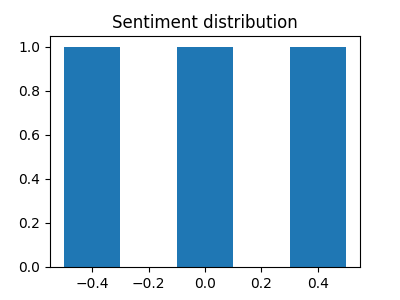

## Report for ExampleCo

# Report — ExampleCo

**Avg sentiment:** 0.50

## Top themes

- shipping (mentions: 1)

- battery (mentions: 1)

- ui (mentions: 1)


## Recommendations

- **Investigate battery issues** — Impact: Medium, Effort: Medium


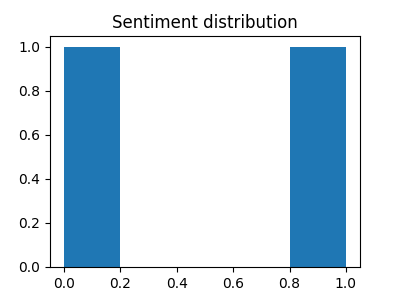

✔ All reports and charts displayed successfully.


In [13]:
from IPython.display import Markdown, Image, display
for comp, info in out["reports"].items():
    display(Markdown(f"## Report for {comp}"))
    display(Markdown(open(info["report_md"], "r", encoding="utf-8").read()))
    display(Image(info["chart"]))
print("✔ All reports and charts displayed successfully.")

Quick sanity checks — assert report files exist and charts are created.

In [14]:
# Simple validation that outputs exist
for comp, info in out["reports"].items():
    assert os.path.exists(info["report_md"]), "Missing md"
    assert os.path.exists(info["chart"]), "Missing chart"
print("Basic checks passed.")

Basic checks passed.


## Next steps & extensions

If you want to extend this prototype:
- Plug in real data sources (NewsAPI, product pages, social streams) and add scraping adapters.
- Replace rule-based sentiment with an LLM-backed or fine-tuned classifier (Gemini/OpenAI).
- Add historical snapshot comparison using the `memory_bank.json` to detect trend deltas.
- Build an interactive dashboard (React) to explore evidence and click through to source snippets.
- Add unit tests that validate parser outputs against labeled HTML pages (see `tests/`).


# --- OLD DEMO PIPELINE ---
(run with AcmeCorp & ExampleCo)

# --- NEW SECTION: REAL DATASET EXTENSION ---
(load Kaggle dataset)
(process real brands)
(show reports)

Load the CSV from the dataset you added and show top brands.

In [15]:
# Cell A: Load dataset and inspect brands
import pandas as pd
DATA_PATH = "/kaggle/input/amazon-reviews-unlocked-mobile-phones/Amazon_Unlocked_Mobile.csv"

print("Loading dataset from:", DATA_PATH)
df_raw = pd.read_csv(DATA_PATH, encoding='utf-8', low_memory=False)
print("Total rows loaded:", len(df_raw))

# Inspect brand column (may be 'brand' or 'manufacturer' or similar — find likely candidate)
possible_brand_cols = [c for c in df_raw.columns if 'brand' in c.lower() or 'manufacturer' in c.lower()]
print("Possible brand columns:", possible_brand_cols)
# Try to infer brand column
brand_col = possible_brand_cols[0] if possible_brand_cols else None
if not brand_col:
    # fallback: try common column names
    for candidate in ['brand','Brand','manufacturer','Manufacturer','company']:
        if candidate in df_raw.columns:
            brand_col = candidate
            break

print("Using brand column:", brand_col)
# Quick look
display(df_raw.head(3))
print("✔ Dataset loaded and brand column identified.")

Loading dataset from: /kaggle/input/amazon-reviews-unlocked-mobile-phones/Amazon_Unlocked_Mobile.csv
Total rows loaded: 413840
Possible brand columns: ['Brand Name']
Using brand column: Brand Name


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0


✔ Dataset loaded and brand column identified.


Normalize columns, compute brand counts, pick top 3 brands.

In [16]:
# Cell B: Clean & select top N brands
NUM_COMPANIES = 3   # change this to run more/less companies
text_col_candidates = [c for c in df_raw.columns if 'review' in c.lower() or 'text' in c.lower() or 'content' in c.lower()]
rating_col_candidates = [c for c in df_raw.columns if 'rating' in c.lower() or 'score' in c.lower() or 'stars' in c.lower()]

print("Text columns candidates:", text_col_candidates)
print("Rating columns candidates:", rating_col_candidates)

# Choose text and rating columns (best guess)
text_col = text_col_candidates[0] if text_col_candidates else df_raw.columns[0]
rating_col = rating_col_candidates[0] if rating_col_candidates else None

# Keep rows with non-null brand and text
df = df_raw[[brand_col, text_col] + ([rating_col] if rating_col else [])].dropna(subset=[brand_col, text_col]).copy()
df[brand_col] = df[brand_col].astype(str).str.strip()
df[text_col] = df[text_col].astype(str).str.strip()

# Compute top brands
brand_counts = df[brand_col].value_counts()
top_brands = brand_counts.head(NUM_COMPANIES).index.tolist()
print(f"Top {NUM_COMPANIES} brands selected:", top_brands)
display(brand_counts.head(10))

Text columns candidates: ['Reviews', 'Review Votes']
Rating columns candidates: ['Rating']
Top 3 brands selected: ['Samsung', 'BLU', 'Apple']


Brand Name
Samsung       65725
BLU           63246
Apple         58179
LG            22410
BlackBerry    16872
Nokia         16805
Motorola      13414
HTC           12724
CNPGD         12613
OtterBox       7987
Name: count, dtype: int64

Create the sample_reviews format for your orchestrator, limit reviews per brand to keep runtime small.

In [17]:
# Cell C: Build sample_reviews dict used by the orchestrator
MAX_REVIEWS_PER_BRAND = 300   # tuning: limit to keep runtime reasonable in Kaggle
sample_reviews_real = {}

for brand in top_brands:
    subset = df[df[brand_col] == brand].head(MAX_REVIEWS_PER_BRAND)
    reviews_list = []
    for idx, row in subset.iterrows():
        rid = f"{brand[:6]}_{idx}"
        text = row[text_col]
        rating = float(row[rating_col]) if rating_col and not pd.isna(row[rating_col]) else None
        # Source and date unknown in this dataset; use placeholders or other columns if available
        src = str(row.get('source','')) if 'source' in row.index else 'kaggle'
        date = str(row.get('review_date', '')) if 'review_date' in row.index else ''
        reviews_list.append({"id": rid, "text": text, "rating": rating, "source": src, "date": date})
    sample_reviews_real[brand] = reviews_list

# Save a copy for reproducibility
save_json(os.path.join(WORKDIR, "sample_reviews_from_kaggle.json"), sample_reviews_real)
print("Built sample_reviews for brands:", list(sample_reviews_real.keys()))
for b in sample_reviews_real:
    print(f" - {b}: {len(sample_reviews_real[b])} reviews")


Built sample_reviews for brands: ['Samsung', 'BLU', 'Apple']
 - Samsung: 300 reviews
 - BLU: 300 reviews
 - Apple: 300 reviews


See a couple of real reviews per brand to confirm format.

In [18]:
# Cell D: Preview 2 reviews per selected brand
for brand, reviews in sample_reviews_real.items():
    print(f"\n=== {brand} (showing up to 2 reviews) ===")
    for r in reviews[:2]:
        print("-", r["text"][:200].replace("\n"," "), "...", f"(rating={r['rating']})")


=== Samsung (showing up to 2 reviews) ===
- I feel so LUCKY to have found this used (phone to us & not used hard at all), phone on line from someone who upgraded and sold this one. My Son liked his old one that finally fell apart after 2.5+ yea ... (rating=5.0)
- nice phone, nice up grade from my pantach revue. Very clean set up and easy set up. never had an android phone but they are fantastic to say the least. perfect size for surfing and social media. great ... (rating=4.0)

=== BLU (showing up to 2 reviews) ===
- I bought this phone in May, and it has completely stopped functioning in December.This phone was mainly used to take/receive calls and texts, and watch videos. There were no more than 10 apps download ... (rating=2.0)
- Excellent. ... (rating=5.0)

=== Apple (showing up to 2 reviews) ===
- Was a gift for my husband and he loves it. Replaced a first gen droid so there was no place to go but up.The phone came in a plain white box with charging cable. It looked brand new and

Use your existing Orchestrator class to process the selected brands. Make sure this cell is placed after the Orchestrator definition cell.

In [19]:
# Cell E: Run orchestrator on top brands (uses existing Orchestrator implementation)
data_for_orch = sample_reviews_real   # map brand -> list of review dicts
orch = Orchestrator(data_for_orch, WORKDIR)
result_real = orch.run_companies(list(data_for_orch.keys()))

print("Run complete:", result_real["run_id"])
for comp, info in result_real["reports"].items():
    print(f"{comp}: report saved to {info['report_md']}, chart saved to {info['chart']}")

Run complete: run_1763649887
Samsung: report saved to /kaggle/working/bizinsight_ai/report_Samsung.md, chart saved to /kaggle/working/bizinsight_ai/Samsung_sent_hist.png
BLU: report saved to /kaggle/working/bizinsight_ai/report_BLU.md, chart saved to /kaggle/working/bizinsight_ai/BLU_sent_hist.png
Apple: report saved to /kaggle/working/bizinsight_ai/report_Apple.md, chart saved to /kaggle/working/bizinsight_ai/Apple_sent_hist.png


Display the markdown report and sentiment chart for each brand.

## Report for Samsung

# Report — Samsung

**Avg sentiment:** 0.41

## Top themes

- battery (mentions: 30)

- price (mentions: 19)

- ui (mentions: 17)

- shipping (mentions: 6)

- support (mentions: 4)

- performance (mentions: 2)

- discount (mentions: 1)


## Recommendations

- **Investigate battery issues** — Impact: Medium, Effort: Medium


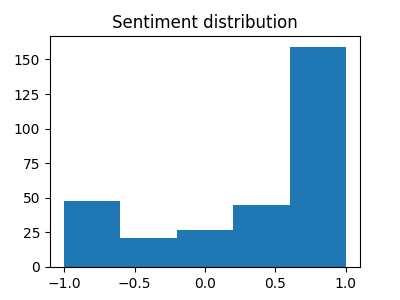

## Report for BLU

# Report — BLU

**Avg sentiment:** 0.34

## Top themes

- price (mentions: 36)

- battery (mentions: 23)

- ui (mentions: 10)

- performance (mentions: 3)

- support (mentions: 2)

- shipping (mentions: 1)


## Recommendations

- **Investigate battery issues** — Impact: Medium, Effort: Medium


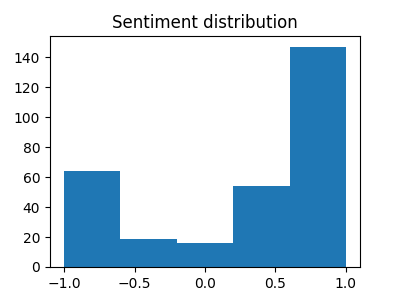

## Report for Apple

# Report — Apple

**Avg sentiment:** 0.39

## Top themes

- price (mentions: 27)

- ui (mentions: 21)

- battery (mentions: 10)

- shipping (mentions: 8)


## Recommendations

- **Investigate battery issues** — Impact: Medium, Effort: Medium


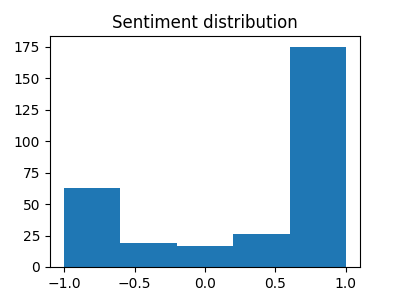

In [20]:
# Cell F: Display reports & charts inline for each brand
for comp, info in result_real["reports"].items():
    display(Markdown(f"## Report for {comp}"))
    with open(info["report_md"], "r", encoding="utf-8") as f:
        display(Markdown(f.read()))
    display(Image(info["chart"]))